In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn
import logomaker
from importlib import reload
import motifscanner

#IP_peak_file = "/gpfs/commons/home/daknowles/RIPnet/all_hnrnpk_rep1_stranded.narrowPeak.gz"
IP_peak_file = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/alignments/macs/all_hnrnpa1_rep1_stranded_noigg.narrowPeak"
unbound_bed_file = "unbound_regions/HNRNPK_unbound.bed.gz"
RBP = "HNRNPK"
pwm_source = "K562" # "oRNAment" # HepG2, K562 both imply mCross

NameError: name 'K562' is not defined

## Loading data

In [29]:
binding_data = pd.read_csv(IP_peak_file, sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data

,chrom,start,end,name,score,strand
0,chr1,16099,16580,all_hnrnpk_rep1_neg_peak_35,81,-
1,chr1,19237,19896,all_hnrnpk_rep1_neg_peak_36,48,-
2,chr1,136471,137136,all_hnrnpk_rep1_neg_peak_37,73,-
3,chr1,186383,187169,all_hnrnpk_rep1_neg_peak_38,54,-
4,chr1,190825,191102,all_hnrnpk_rep1_neg_peak_39,51,-
...,...,...,...,...,...,...
149418,chr9,138179008,138179394,all_hnrnpk_rep1_pos_peak_74674,72,+
149419,chr9,138232102,138232344,all_hnrnpk_rep1_pos_peak_74675,362,+
149420,chr9,138232980,138233211,all_hnrnpk_rep1_pos_peak_74676,254,+
149421,chr9,138276024,138276247,all_hnrnpk_rep1_pos_peak_74677,340,+


In [30]:
unbound = pd.read_csv(unbound_bed_file, 
                      sep = "\t", 
                      names = ["chrom", "start", "end", "name", "strand", "counts", "length"],
                      index_col = False)
unbound

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,chrom,start,end,name,strand,counts,length
0,chr1,17369,17436,ENSG00000278267.1,-,53,68
1,chr1,135141,135895,ENSG00000268903.1,-,903,755
2,chr1,137682,137965,ENSG00000269981.1,-,1206,284
3,chr1,185217,186383,ENSG00000279457.4,-,295,1397
4,chr1,187169,190825,ENSG00000279457.4,-,295,1397
...,...,...,...,...,...,...,...
126565,chrM,14149,14673,ENSG00000198695.2,-,59390,525
126566,chrM,14674,14742,ENSG00000210194.1,-,598,69
126567,chrM,14747,15887,ENSG00000198727.2,+,247327,1141
126568,chrM,15888,15953,ENSG00000210195.2,+,663,66


In [31]:
unbound["score"] = 0
bind_all = pd.concat([binding_data,
           unbound.loc[:, ~unbound.columns.isin(['counts', 'length'])]], 
          axis=0)
bind_all.iloc[10]

chrom                            chr1
start                          629752
end                            629972
name      all_hnrnpk_rep1_pos_peak_23
score                             246
strand                              +
Name: 74767, dtype: object

In [32]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.09493766126042802, 0.1428707751144192)

We'll also need the human genome, which we provide here as a pickle since it's faster to load compared to reading in a text file. 

It's worth knowing that the human genome has different *versions* that are released as more missing parts are resolved by continued sequencing and assembly efforts. Version `GRCh37` (also called `hg19`) was released in 2009, and `GRCh38` (`hg38`) was released in 2013. We'll be using `hg19` here but `GRCh38` is finally becoming more standard so always check your data is what you think it is. 

This will take a minute or two. 

In [33]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

`genome` is just a dictionary where the keys are the chromosome names and the values are strings representing the actual DNA. Ns represents "missing" regions, typically because the region has too many repetitive sequences making mapping impossible, which is especially the case in [centrosomes](https://en.wikipedia.org/wiki/Centrosome) and [telomeres](https://en.wikipedia.org/wiki/Telomere). Resolving these difficult to map regions is an ongoing effort. 

## Load known PWMs

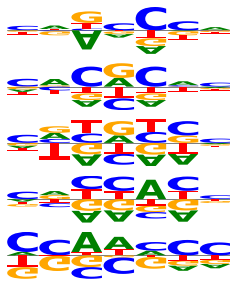

In [34]:
if pwm_source == "oRNAment":
    pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
    pwm_names = pwm_dat['names']
    pwms = pwm_dat['pwms']

    pwms[pwms > 0].min()
    log_pwms = np.log(pwms + 1e-4)

    # Convert to actual PWM
    w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
    w_norm = w - w.mean(1,keepdims=True)

    specific_pwms = w_norm[ np.array([ RBP in g for g in pwm_names ]) ]
    specific_pwms.shape
else: 
    base_dir = "/gpfs/commons/groups/knowles_lab/data/oRNAment/mCross/"
    pwm = np.load(base_dir + "mCross_pwm.npy")
    meta = pd.read_csv(base_dir + "pwm_meta.tsv", sep = "\t")
    #specific_motifs = (meta.RBP == RBP) & (meta.Celltype == "HepG2").to_numpy()
    
    specific_motifs = (meta.RBP == RBP) & (meta.Celltype == pwm_source).to_numpy()
    specific_pwms = torch.tensor(pwm[specific_motifs,:,:], dtype = torch.float)
    specific_pwms -= specific_pwms.mean(1, keepdims=True)

biophysnn.plot_motifs(specific_pwms)

In [36]:
validation_data

,chrom,start,end,name,score,strand
34934,chr2,217616,217866,all_hnrnpk_rep1_neg_peak_34969,34,-
34935,chr2,226497,227354,all_hnrnpk_rep1_neg_peak_34970,198,-
34936,chr2,228295,228931,all_hnrnpk_rep1_neg_peak_34971,46,-
34937,chr2,234437,235333,all_hnrnpk_rep1_neg_peak_34972,92,-
34938,chr2,236234,236903,all_hnrnpk_rep1_neg_peak_34973,210,-
...,...,...,...,...,...,...
28836,chr3,198015944,198043720,ENSG00000185621.11,0,+
28837,chr3,198153287,198167944,ENSG00000236438.7,0,+
28838,chr3,198169762,198182452,ENSG00000236438.7,0,+
28839,chr3,198183005,198220091,ENSG00000236438.7,0,+


## Test phys net

In [39]:
base_checkpoint_dir =  "checkpoints/%s_%s/" % (RBP, pwm_source)
reload(motifscanner)
reload(biophysnn)
res_df = motifscanner.test_settings(
    specific_pwms, 
    train_data, 
    validation_data,
    genome, 
    base_checkpoint_dir = base_checkpoint_dir)
res_df.to_csv("biophys_results/test_settings_%s_%s.tsv" % (RBP, pwm_source), sep = "\t", index = False)

checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len100.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len200.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len300.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len400.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len500.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len600.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len700.pt
checkpoints/HNRNPK_oRNAment/posmax0_motifmax0_len800.pt


KeyboardInterrupt: 

### Analyze results

In [ ]:
lse_only = res_df[~res_df.posmax & ~res_df.motifmax]
plt.plot(lse_only.seqlen, lse_only.val_auc)

In [ ]:
sixh_only = res_df.groupby(["motifmax","posmax","motif_then_pos"]).agg({"val_auc" : "max"})
sixh_only

The best performance is obtained by using logSumExp across both motifs and positions, which is symmetric in the order of summarization. Taking the max over positions always performs very poorly, suggesting that accounting for multiple binding sites in the region is beneficial, at least for HNRNPK. 

Taking the max over motifs but logSumExp over positions gives intermediate performance. Interestingly, it is better to do the max over motifs first, then logSumExp over positions (rather than logSumExp over positions then max over motifs). This is intuitive. If there are two distinct binding sites in a region, there is no reason to think that the same motif need be used in both. Instead, the max determines how likely the RBP is to bind at any given position, and this is combined by the logSumExp. 

In [ ]:
import seaborn as sns
#res_df = pd.read_csv("biophys_results/results.tsv", sep="\t", index_col = False)
sns.scatterplot("seqlen", "val_auc", hue = "posmax", style="motifmax", size="motif_then_pos", data = res_df)
plt.xlabel("Sequence length")
plt.ylabel("Validation AUROC")
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)

In [ ]:
res_df

In [ ]:
best_i = res_df.val_auc.argmax()
check_point_filename = res_df.file.iloc[best_i]
phys_net = motifscanner.PhysNet(
    specific_pwms, 
    max_over_positions = res_df.posmax.iloc[best_i], 
    max_over_motifs = res_df.motifmax.iloc[best_i], 
    seq_len = res_df.seqlen.iloc[best_i],
    motif_then_pos = res_df.motif_then_pos.iloc[best_i] )
phys_net.load_state_dict(torch.load(check_point_filename))
for k,v in phys_net.named_parameters(): 
    print(k,v)

In [ ]:
phys_net.scale

In [ ]:
phys_net.motif_scale

### Plot examples

In [ ]:
val_dataset = bindingdata.FastBedPeaksDataset(validation_data, genome, phys_net.seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10000)
for x,y in validation_dataloader: 
    affin = phys_net(x)
    conv_lin = F.conv1d(x, phys_net.pwm, padding = "same") * phys_net.motif_scale[None,:,None] + phys_net.motif_offset[None,:,None]
    per_position = phys_net.scale * conv_lin.logsumexp(1) + phys_net.offset
    break

bound = y == 1.
idx = affin[bound].argmax().item()
plt.plot(per_position[bound][idx].detach().exp().numpy())

argmax_pos = per_position[bound][idx].argmax().item()
argmax_motif = conv_lin[bound][idx,:,argmax_pos].argmax().item()
argmax_pos, argmax_motif

In [ ]:
one_motif = phys_net.scale * conv_lin[bound][idx,argmax_motif] + phys_net.offset
plt.plot(one_motif.detach().exp().numpy())

Clusters are cool.

In [ ]:
pwm_match = phys_net.pwm[argmax_motif,:,:]

pwm_df = pd.DataFrame(data = pwm_match.detach().t().numpy(), columns=("A","C","G","T"))
crp_logo = logomaker.Logo(pwm_df) 
plt.axis('off')

In [ ]:
one_motif.argmax().item()

In [ ]:
npos = 10
top_pos = one_motif.argsort(descending=True)[:npos]
plt.figure(figsize=(4,npos))
        
for i,tp in enumerate(top_pos):
    ax = plt.subplot(npos,1,i+1)
    seq = x[bound][idx,:,tp-7:tp+7]
    pwm_df = pd.DataFrame(data = seq.detach().t().numpy(), columns=("A","C","G","T"))
    crp_logo = logomaker.Logo(pwm_df, ax= ax) 
    plt.axis('off')

## Fine tune PWMs

In [ ]:
scaled_pwm = specific_pwms * phys_net.motif_scale[:,None,None]
fine_net = biophysnn.FinePhysNet(scaled_pwm, 
                                 motif_offset = phys_net.motif_offset.data,
                                 scale_unc = phys_net.scale_unc.data, 
                                 offset = phys_net.offset.data, 
                                 seq_len = phys_net.seq_len)
train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(fine_net, 
                                                       train_data, 
                                                       validation_data, 
                                                       genome, 
                                                       verbose = True, 
                                                       check_point_filename = base_checkpoint_dir + "/fine_net.pt",
                                                       lr = 0.1) # val auc 0.832

So fine-tuning moves AUROC from 0.81 to 0.86, and does significantly change the PWMs: 

In [ ]:
torch.corrcoef(torch.stack([scaled_pwm.flatten(), fine_net.pwm.cpu().flatten()]))

In [ ]:
biophysnn.plot_motifs(specific_pwms)

In [ ]:
plot_motifs(fine_net.pwm.cpu())